<h1>CS166: Traffic Simulation Assignment</h1>
<h2>Part 1: Traffic Jams on a Circular Road</h2>
<h3>Nagel-Schreckenberg Model</h3>

Single-lane, Variable speed, Traffic Model

In [110]:
#import libraries
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import copy
sns.set()
%matplotlib inline

In [61]:
class TrafficSimulation:

    def __init__(self, length=100, car_density=0.2, slow_down_prob=0.5, max_speed=5, demo = False):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            slow_down_prob (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.demo = demo
        self.length = length
        self.max_speed = max_speed
        self.slow_down_prob = slow_down_prob

        # Track the time steps and total number of cars that passed the simulation
        # boundary to estimate average traffic flow.
        self.time_step = 0
        self.cumulative_traffic_flow = 0

        random_indexes = np.random.choice(
            range(self.length),
            size=int(round(car_density * self.length)),
            replace=False)
        self.state = -np.ones(self.length, dtype=int)  # -1 means empty cell
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

    def step(self):
        '''
        Advance one time step in the simulation.
        '''

        # Update car velocities.
        for i in range(self.length):
            if self.state[i] != -1: #if the index is a car
                distance = 1  # The number of empty cells between this car and the next plus 1
                while self.state[(i + distance) % self.length] == -1:
                    distance += 1
                # Acceleration
                if self.state[i] < self.max_speed:
                    self.state[i] += 1
                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1
                # Randomization
                if (self.state[i] > 0) and (np.random.uniform() < self.slow_down_prob):
                    self.state[i] -= 1

        if self.demo:
            self.display()

        # Move cars forward using their new velocities
        new_state = -np.ones(self.length, dtype=int)
        for i in range(self.length):
            if self.state[i] != -1:
                new_state[(i + self.state[i]) % self.length] = self.state[i]
        self.state = new_state

        # Update time and traffic flow
        self.time_step += 1
        for i in range(self.max_speed):
            if self.state[i] > i:
                self.cumulative_traffic_flow += 1

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state))
        
        

In [68]:
sim = TrafficSimulation(car_density=0.1,demo=True)
for i in range(10):
    sim.step()

.............0................4.....2........4......4.......4...................2..3........4.....5.
...5.........0....................2...3..........5......5.......4.................2...4.........4...
4.......3....1......................3....4............4......5......5...............2.....5.........
....4......1..1........................3.....4............4.......4......4............3........4....
........2...1..1..........................3......4............4.......4......4...........3.........5
....4.....1..1..1............................4.......4............5.......5......5..........3.......
........1..1..1..2...............................5.......4.............5.......4......5........3....
.........2..2..1...2..................................4......5..............5......4.......5......4.
..4........1..0.1....2....................................4.......5..............4.....5........4...
5.....4.....0.1..1.....2......................................5........4.............5.....

In [51]:
# Simulate higher traffic density to see traffic jams forming
density = np.arange(0,1,0.05)
avg_traffic_flows = []
mean_traffic_flows = []
for i in density:
    q_temp = 0
    for t in range(100):
        sim = TrafficSimulation(car_density=i)
        for j in range(100):
            sim.step()
            q_temp += sim.cumulative_traffic_flow / sim.time_step
        avg_traffic_flows.append((i, sim.cumulative_traffic_flow / sim.time_step))
    mean_traffic_flows.append(q_temp/10000.)
    

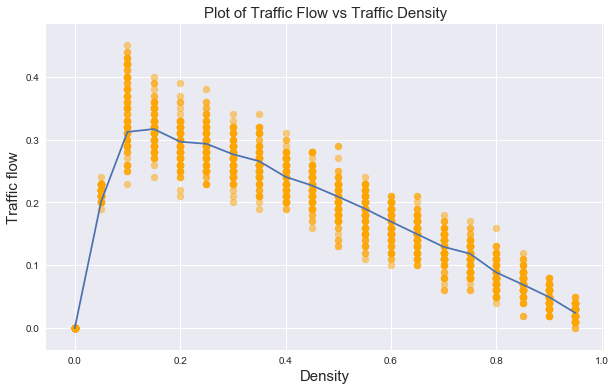

In [64]:
traffic_flows = np.array(avg_traffic_flows)
plt.figure(figsize=(10,6))
plt.scatter(traffic_flows[:,0],traffic_flows[:,1], alpha = 0.5, c="orange")
plt.plot(density, mean_traffic_flows)
plt.title("Plot of Traffic Flow vs Traffic Density",size=15)
plt.xlabel("Density",size=15)
plt.ylabel("Traffic flow",size=15)
plt.show()

<h2>Part 2: Multi-lane Highways</h2>
<h3>Two-lane Traffic Simulation Model</h3>

Two-lane, symmetric, uni-directional, variable speed model.

In [294]:
class TrafficSimulation2:

    def __init__(self, length=80, car_density=0.3, slow_down_prob=0, switch_lane_prob=1, max_speed=5, demo = False):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            slow_down_prob (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.demo = demo
        self.length = length
        self.max_speed = max_speed
        self.slow_down_prob = slow_down_prob
        self.switch_lane_prob = switch_lane_prob

        # Track the time steps and total number of cars that passed the simulation
        # boundary to estimate average traffic flow.
        self.time_step = 0
        self.cumulative_traffic_flow = 0
        
        #function for initializing lane according to road length and density
        def create_lane(car_density):
            
            random_indexes = np.random.choice(range(self.length),                   
                                                size=int(np.ceil(car_density * self.length)),                
                                                replace=False)
            state = -np.ones(self.length, dtype=int)  # -1 means empty cell
            state[random_indexes] = np.random.randint(0, self.max_speed + 1, 
                                                      size=len(random_indexes))
    
            return state
        
        #randomly divide the density among two lanes
        density_denom = np.random.randint(2,10)
        car_density_1 = car_density/density_denom
        car_density_2 = car_density - car_density_1
        
        #create two lanes in the state array
        self.state = np.array([create_lane(car_density_1), create_lane(car_density_2)])
            
        
    def get_distances(self, curr_lane, index):
        '''
        Get the front and back distances of the given car.
        
        Inputs: 
        
            curr_lane: The current road that the car is on (numpy array)
            index: The index of the current car.
            
        Outputs: 
            
            front_dist: The available front distance of the current car.
            back_dist: The available back distance of the current car.
            distance is the number of empty cells between current car and next car plus 1.
        '''
        
        front_dist, back_dist = 1,1

        while curr_lane[(index + front_dist) % len(curr_lane)] == -1:
            front_dist += 1
            if front_dist >= 6: break
        while curr_lane[(index - back_dist) % len(curr_lane)] == -1:
            back_dist += 1
            if back_dist >= 6: break
                
        return front_dist, back_dist
    
    def move_cars(self):
        
        '''
        Move cars forward using their new velocities
        '''
        
        # initialize new two-lane state
        new_state = np.array([-np.ones(self.length, dtype=int),-np.ones(self.length, dtype=int)])
        
        #loop through lanes and update each cell in each lane
        for lane in range(len(self.state)):
            for i in range(self.length):
                if self.state[lane][i] != -1:
                    new_state[lane][(i + self.state[lane][i]) % self.length] = self.state[lane][i]
                    
        return new_state    
    
    def update_cars(self,old_state, curr_lane_index,other_lane_index):
        '''
        Update car velocities / switch lanes and update velocities
        '''
        # Update car velocities 
        for i in range(self.length):
            if old_state[curr_lane_index][i] != -1: #if the index is a car
                
                #get front and back distance of current lane
                f_dist, b_dist = self.get_distances(old_state[curr_lane_index], i)
                
                #get front and back distance of other lane
                fo_dist, bo_dist = self.get_distances(old_state[other_lane_index], i)
                
                #if there is enough front distance in curr lane, either accelerate or maintain the max velocity
                if old_state[curr_lane_index][i] + 1 <= f_dist:
                    self.state[curr_lane_index][i] = min(old_state[curr_lane_index][i] + 1, self.max_speed)

                #if there is not enough front distance, check the other lane
                else:

                    #if it's safe to switch to other lane, switch lane with probability switch_lane_prob.
                    if old_state[curr_lane_index][i] + 1 <= fo_dist and bo_dist >= self.max_speed:
                        if np.random.uniform() < self.switch_lane_prob:
                            self.state[other_lane_index][i] = min(old_state[curr_lane_index][i] + 1, self.max_speed)
                            self.state[curr_lane_index][i] = -1
                            #print(f'lane switch occurred at index {i} for lane {curr_lane_index}!')

                    #if not, decelerate in current lane
                    else: self.state[curr_lane_index][i] = f_dist - 1

                # Random slow down
                if (old_state[curr_lane_index][i] > 0) and (np.random.uniform() < self.slow_down_prob): 
                    self.state[curr_lane_index][i] -= 1
        
    def get_traffic_flow(self):
        self.time_step += 1
        for i in range(self.max_speed):
            if self.state[0][i] > i:
                self.cumulative_traffic_flow += 1
            if self.state[1][i] > i:
                self.cumulative_traffic_flow += 1
        
    def step(self):
        '''
        Advance one time step in the simulation.
        '''
        #create deep copy of current state for reference when updating both lanes
        old_state = copy.deepcopy(self.state) 
        
        #update car velocities / switch lanes and update velocities
        self.update_cars(old_state,0,1)
        self.update_cars(old_state,1,0)

        #if demo == True, display the traffic sim
        if self.demo: self.display()

        #move cars
        self.state = self.move_cars()

        #Update time and traffic flow
        self.get_traffic_flow()

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state[0]))
        print(''.join('.' if x == -1 else str(x) for x in self.state[1]))
        print()
        
        

In [295]:
np.random.seed(2004)

sim = TrafficSimulation2(car_density=0.2,demo=True)
for i in range(10):
    sim.step()
    
#issues
#lane 2 is not moving correctly - only increasing by 1 step

........2.....4.........2.................4.........1.......5............4......
.........1.......5.....15......1.............5.........4.......5...........3..4.

..........3.......5.......3...................5......2...........5...........5..
..5.......2...........1.2....2..2.................5........5........5.........4.

..5....5.....4.........5.....4.....................3...3..............5.........
..5.........3..........2..3....3..3....................5........5........5......

............4....5..........4....5....................4...4................5....
.......5.......4.........3...4....2..4......................5........5........5.

5...............5.....5.........5.....5.......................5.................
...5........5......5........4....2..3....5................5......5........5.....

.....5...............5.....5....5....5.....5.......................5............
........5........5......5..........3...4......5................5......5........5

..........5...........

In [302]:
# Simulate higher traffic density to see traffic jams forming
density = np.arange(0,1,0.05)
avg_traffic_flows = []
mean_traffic_flows = []
for i in density:
    q_temp = 0
    for t in range(100):
        sim = TrafficSimulation2(car_density=i)
        for j in range(100):
            sim.step()
            q_temp += sim.cumulative_traffic_flow / sim.time_step
        avg_traffic_flows.append((i, sim.cumulative_traffic_flow / sim.time_step))
    mean_traffic_flows.append(q_temp/10000.)
    

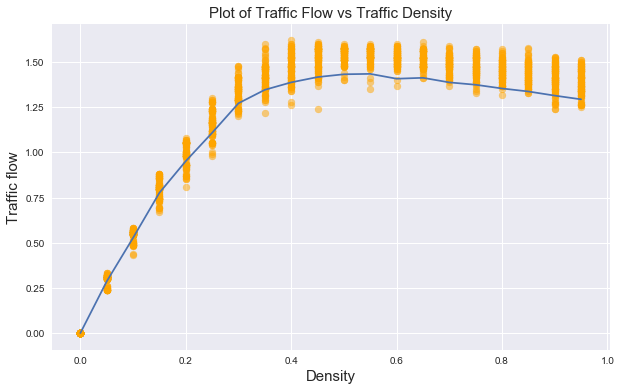

In [303]:
traffic_flows = np.array(avg_traffic_flows)
plt.figure(figsize=(10,6))
plt.scatter(traffic_flows[:,0],traffic_flows[:,1], alpha = 0.5, c="orange")
plt.plot(density, mean_traffic_flows)
plt.title("Plot of Traffic Flow vs Traffic Density",size=15)
plt.xlabel("Density",size=15)
plt.ylabel("Traffic flow",size=15)
plt.show()

Potential HCs: 
- estimation (estimating the traffic flow on 3-lane or higher models)
- descriptivestats
- confidenceinterval (explaning the confidence intervals included in the traffic flow plot)
- systemdynamics (identify potential attractor states - what are the typical "stable states" of the models?)
- studyreplication (replicating nagel-schreckenberg and rickert et al.'s models + extending on them)

Questions for Scheffler:

- For two-lane:
    - should car_density mean density of the whole system? For example, should 0.1 density for a single-lane == 0.2 density for the two-lane, or 0.1 density for the whole two-lane system (which means 0.05 density per lane for the whole two-lane system)?
    - adding on to that, should we let the user define the density for lane 1 and lane 2, or should they just put the density for the whole system and we randomize the ratio split? Or should we always split the ratio in half, etc.?